In [26]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import prince
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import joblib
import pickle

In [27]:
data = pd.read_csv('imputed_dataset.csv')

In [28]:
print(f"Unique values in workclass: {data['workclass'].unique()}: {data['workclass'].unique().size} unique values\n")
print(f"Unique values in occupation: {data['occupation'].unique()}: {data['occupation'].unique().size} unique values")

Unique values in workclass: [3.  1.  2.6 5.  0.  3.8 6.  4.  3.4 3.6 4.4 4.6 4.2 2.4 1.6 3.2 2.8 5.2
 2.  2.2 7.  4.8 1.2 1.8 5.4 1.4 5.6 0.2 0.6]: 29 unique values

Unique values in occupation: [ 6.   4.  11.  10.4  8.   5.6 10.   2.   0.   6.6  3.  13.   7.8 12.
  7.4  9.  14.   5.   1.   9.4  1.6  5.2  4.4  4.8  4.6  7.   8.6  6.2
 11.4  9.6  6.8  7.2  5.8  8.8  8.2  8.4  3.2  6.4  3.6  9.2 10.2  4.2
  3.8  7.6  5.4  1.2 10.6 11.2  2.8 12.4  2.4  2.2  3.4 10.8  9.8  2.6
 11.8 11.6  0.4 12.2  1.8  0.6 13.2  1.4 12.6]: 65 unique values


**One hot encoding (workclass and occupation)**

In [30]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[['workclass', 'occupation']])
encoded_columns_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

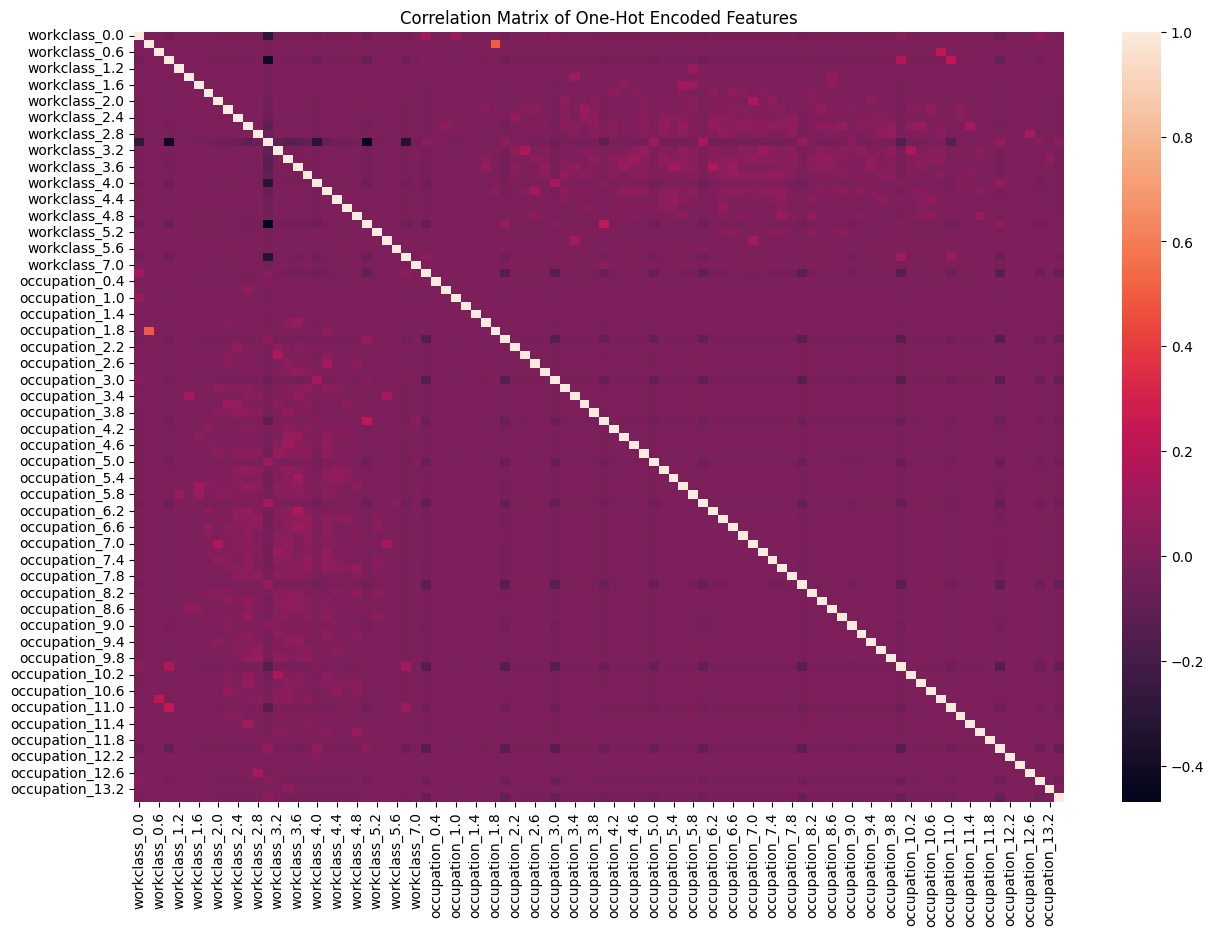

In [31]:
correlation_matrix = encoded_columns_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix)
plt.title('Correlation Matrix of One-Hot Encoded Features')
plt.show()

****Dimensionality reduction Phase**** <br>
Testing MCA vs PCA

**MCA**


In [21]:
mca = prince.MCA(
    one_hot=False,
    n_components=23
    )

mca_coords = mca.fit_transform(encoded_columns_df)

In [22]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.566,6.65%,6.65%
1,0.500,5.88%,12.54%
2,0.493,5.80%,18.34%
3,0.382,4.49%,22.83%
4,0.338,3.98%,26.81%
5,0.310,3.65%,30.46%
6,0.296,3.48%,33.94%
7,0.289,3.40%,37.34%
8,0.282,3.32%,40.66%


**MCA separately for workclass and occupation <br>**
Testing if using MCA separately for the workclass features and occupation is improving the descriptive performances

In [23]:
# Separate the encoded columns
workclass_cols = [col for col in encoded_columns_df.columns if 'workclass' in col]
occupation_cols = [col for col in encoded_columns_df.columns if 'occupation' in col]

# Create two separate MCAs
mca_workclass = prince.MCA(n_components=8)
mca_occupation = prince.MCA(n_components=15)

# Fit and transform separately
workclass_transformed = mca_workclass.fit_transform(encoded_columns_df[workclass_cols])
occupation_transformed = mca_occupation.fit_transform(encoded_columns_df[occupation_cols])

# Check eigenvalues summaries
print("Workclass Components:")
print(mca_workclass.eigenvalues_summary)
print("\nOccupation Components:")
print(mca_occupation.eigenvalues_summary)

Workclass Components:
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.193        19.30%                     19.30%
1              0.120        11.99%                     31.29%
2              0.118        11.83%                     43.11%
3              0.117        11.65%                     54.77%
4              0.115        11.54%                     66.30%
5              0.115        11.46%                     77.77%
6              0.111        11.12%                     88.89%
7              0.111        11.11%                    100.00%

Occupation Components:
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.072         7.15%                      7.15%
1              0.071         7.14%                     14.29%
2              0.071         7.09%                     21.38%
3              0.071    

**PCA**

In [24]:
pca_net = PCA(n_components=10)

pca_result_net = pca_net.fit_transform(encoded_columns_df)

pca_columns = [f'pca_component_{i+1}' for i in range(10)]

pca_df = pd.DataFrame(pca_result_net, columns=pca_columns)

joblib.dump(encoder, 'onehot_encoder.joblib')
joblib.dump(pca_net, 'pca.joblib')

model_pkl_file = "pca.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(pca_net, file)

one_hot_file = "onehot_encoder.pkl"  

with open(one_hot_file, 'wb') as file:  
    pickle.dump(encoder, file)


In [25]:
pca = PCA(n_components=22)

pca_result = pca.fit_transform(encoded_columns_df)

# Let's look at the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

for i, (var, cum_var) in enumerate(zip(explained_variance_ratio[:22], cumulative_variance_ratio[:22]), 1):
    print(f"Component: {i}, Variance Explained: {var * 100:.2f}%, Cumulative Variance Explained: {cum_var * 100:.2f}%")

Component: 1, Variance Explained: 24.49%, Cumulative Variance Explained: 24.49%
Component: 2, Variance Explained: 9.66%, Cumulative Variance Explained: 34.14%
Component: 3, Variance Explained: 8.92%, Cumulative Variance Explained: 43.06%
Component: 4, Variance Explained: 6.50%, Cumulative Variance Explained: 49.57%
Component: 5, Variance Explained: 4.60%, Cumulative Variance Explained: 54.16%
Component: 6, Variance Explained: 4.49%, Cumulative Variance Explained: 58.65%
Component: 7, Variance Explained: 4.12%, Cumulative Variance Explained: 62.77%
Component: 8, Variance Explained: 4.03%, Cumulative Variance Explained: 66.80%
Component: 9, Variance Explained: 3.78%, Cumulative Variance Explained: 70.58%
Component: 10, Variance Explained: 3.50%, Cumulative Variance Explained: 74.09%
Component: 11, Variance Explained: 3.16%, Cumulative Variance Explained: 77.24%
Component: 12, Variance Explained: 2.66%, Cumulative Variance Explained: 79.90%
Component: 13, Variance Explained: 2.50%, Cumula

C:\Users\User\AppData\Local\Temp\ipykernel_26020\1087372284.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ro-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, len(eigenvalues_summary) + 1),
C:\Users\User\AppData\Local\Temp\ipykernel_26020\1087372284.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),


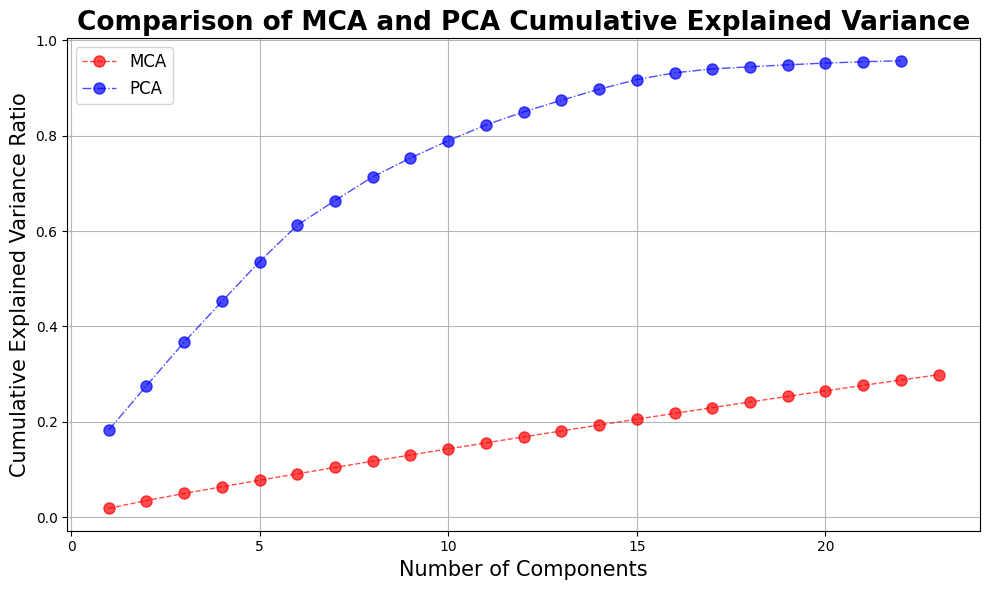

In [12]:
# Get the eigenvalues summary dataframe and convert percentage column to numeric
eigenvalues_summary = mca.eigenvalues_summary
cumulative_variance = pd.to_numeric(eigenvalues_summary['% of variance (cumulative)'].str.rstrip('%')) / 100

plt.figure(figsize=(10, 6))

# Plot both MCA and PCA with different line styles and some transparency
plt.plot(range(1, len(eigenvalues_summary) + 1),
         cumulative_variance, 'ro-', label='MCA', alpha=0.7,
         linestyle='--',  
         linewidth=1,     
         markersize=8)   

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'bo-', label='PCA', alpha=0.7,
         linestyle='-.',  
         linewidth=1,     
         markersize=8)    

plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=15)
plt.title('Comparison of MCA and PCA Cumulative Explained Variance', 
          fontsize=19, fontweight="bold")
plt.grid(True, alpha=0.9)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

**Integrating component columns in the dataset**

In [10]:
data = data.drop(columns=['workclass', 'occupation'], axis=1) #remove the original columns
data = pd.concat([data, pca_df], axis=1) #add the PCA components

In [13]:
data.to_csv('dataset.csv',index=False)

In [14]:
print(joblib.load("pca.joblib"))

PCA(n_components=10)
